# Problema de clasificación utilizando redes neuronales


### Descripción del problema:

Predicción de la probabilidad de impago de un cliente.

El objetivo del problema es predecir la probabilidad de impago de los clientes de tarjetas de crédito. Se trata, por tanto, de un modelo de riesgo de crédito. 

Haremos uso del dataset *default of credit card clients*. Este dataset proviene de la siguiente ruta de la University of California Irvine (**Url:** https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)


### Descripción del dataset:

Cuenta con un total de **24 variables predictoras X** y una **variable continua a predecir Y**.

El número total de muestras es de 30000 personas.


# Carga de librerías:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings('ignore')

# Definición de funciones: 

In [2]:
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4
    tamanio_fig = 4
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4
    fig_tamanio = 4
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))

# Lectura de datos:

In [3]:
# !pip install xlrd
XY = pd.read_excel('default_of_credit_card_clients.xls', skiprows=[0])

In [4]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(XY.columns)))
XY[:2]

- El número de filas en el dataset es: 30000
- El número de columnas en el dataset es: 25
- Los nombres de las variables son: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


## Missings: 

In [5]:
XY.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

## Estudio de la target

In [6]:
XY["default payment next month"].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [7]:
XY["default payment next month"].value_counts()/len(XY)*100

0    77.88
1    22.12
Name: default payment next month, dtype: float64

## Division en features X + target Y 

In [8]:
X = XY.drop(['default payment next month', "ID"], axis=1)
Y = XY['default payment next month']

# Visualizaciones y correlaciones

## Descriptivos básicos:

In [9]:
XY.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Boxplots: 

In [10]:
X_normalizado = (X-X.mean())/X.std()

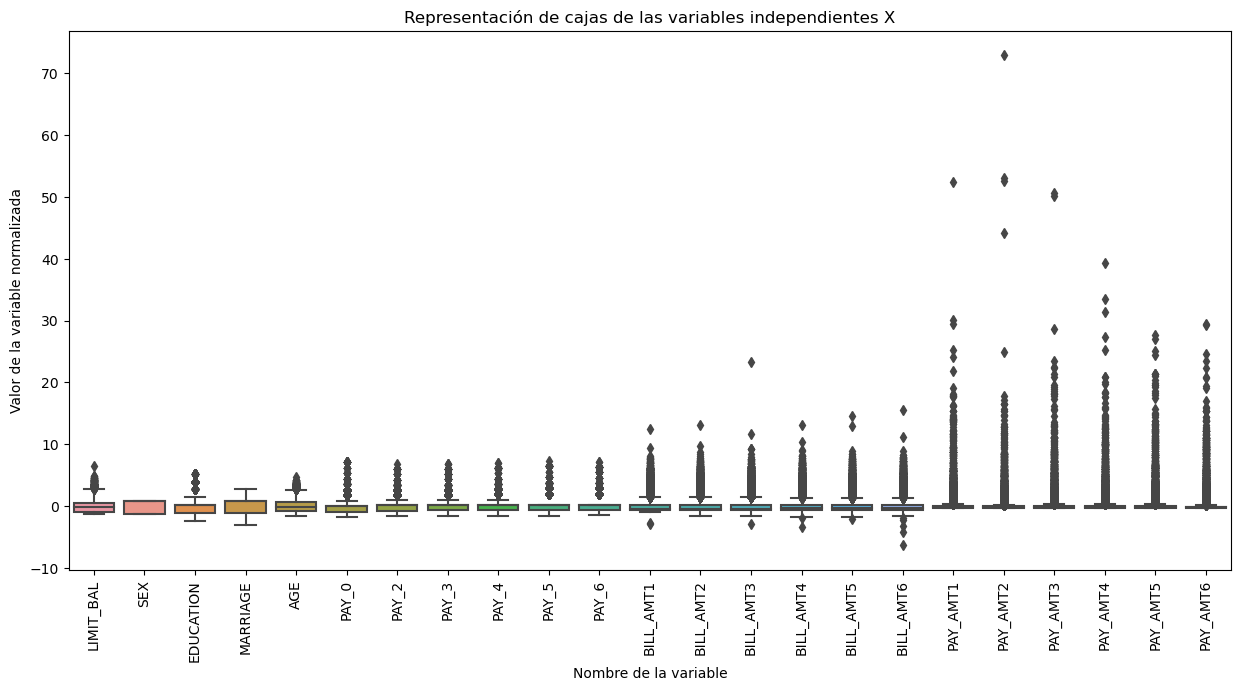

In [11]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

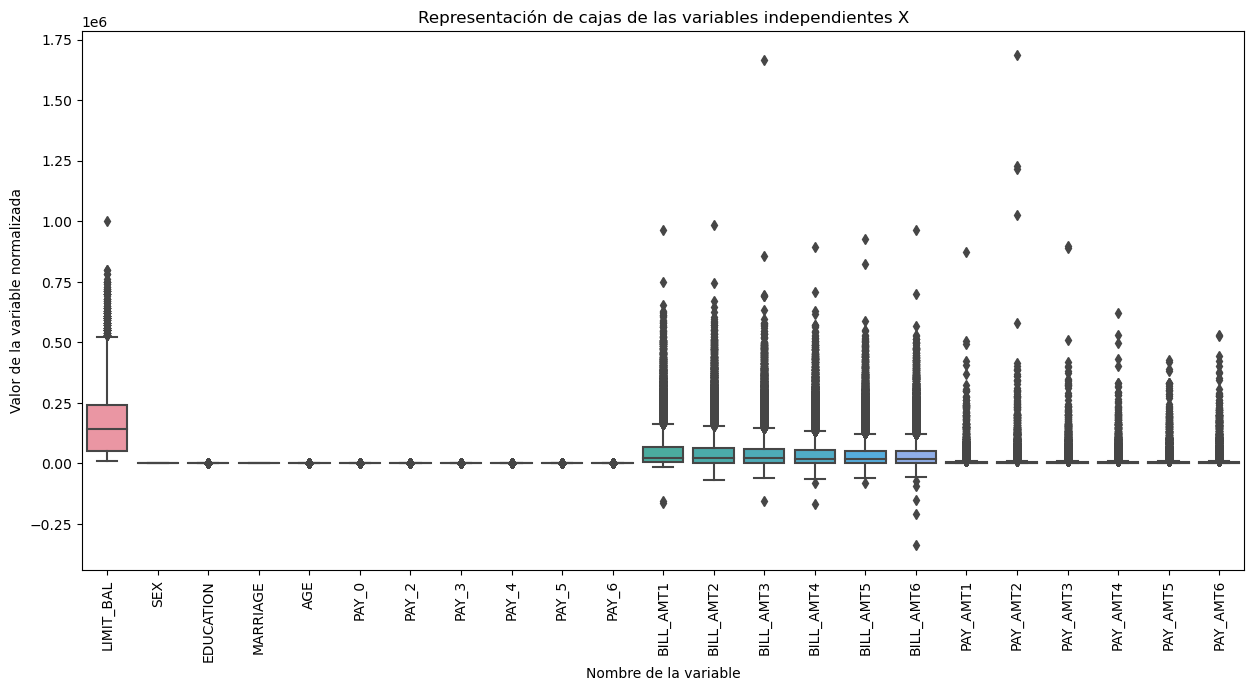

In [12]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

## Histogramas: 

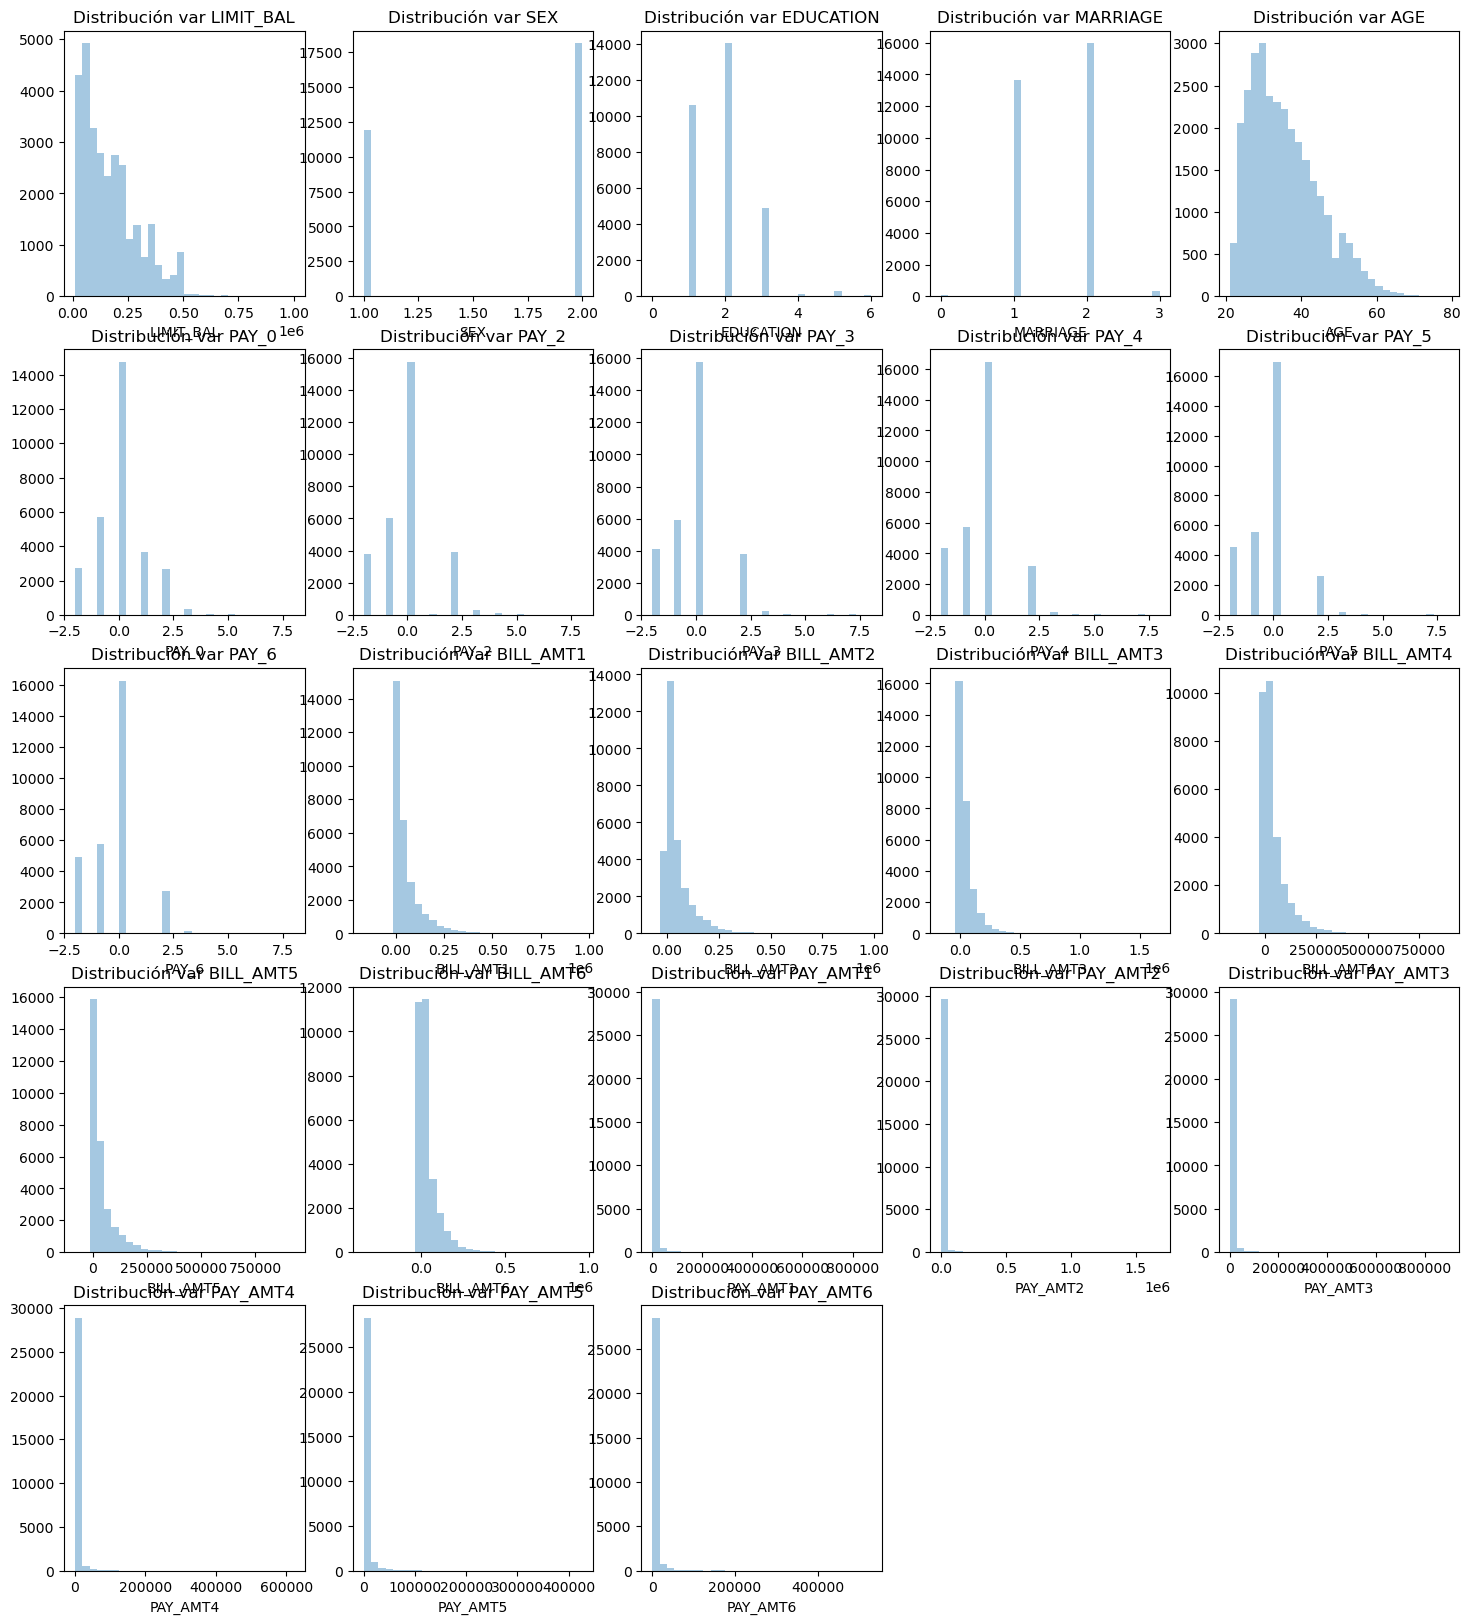

In [13]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(5, 5, n)
    sns.distplot(X[column], bins=30, kde=False)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Relación variable vs target: 

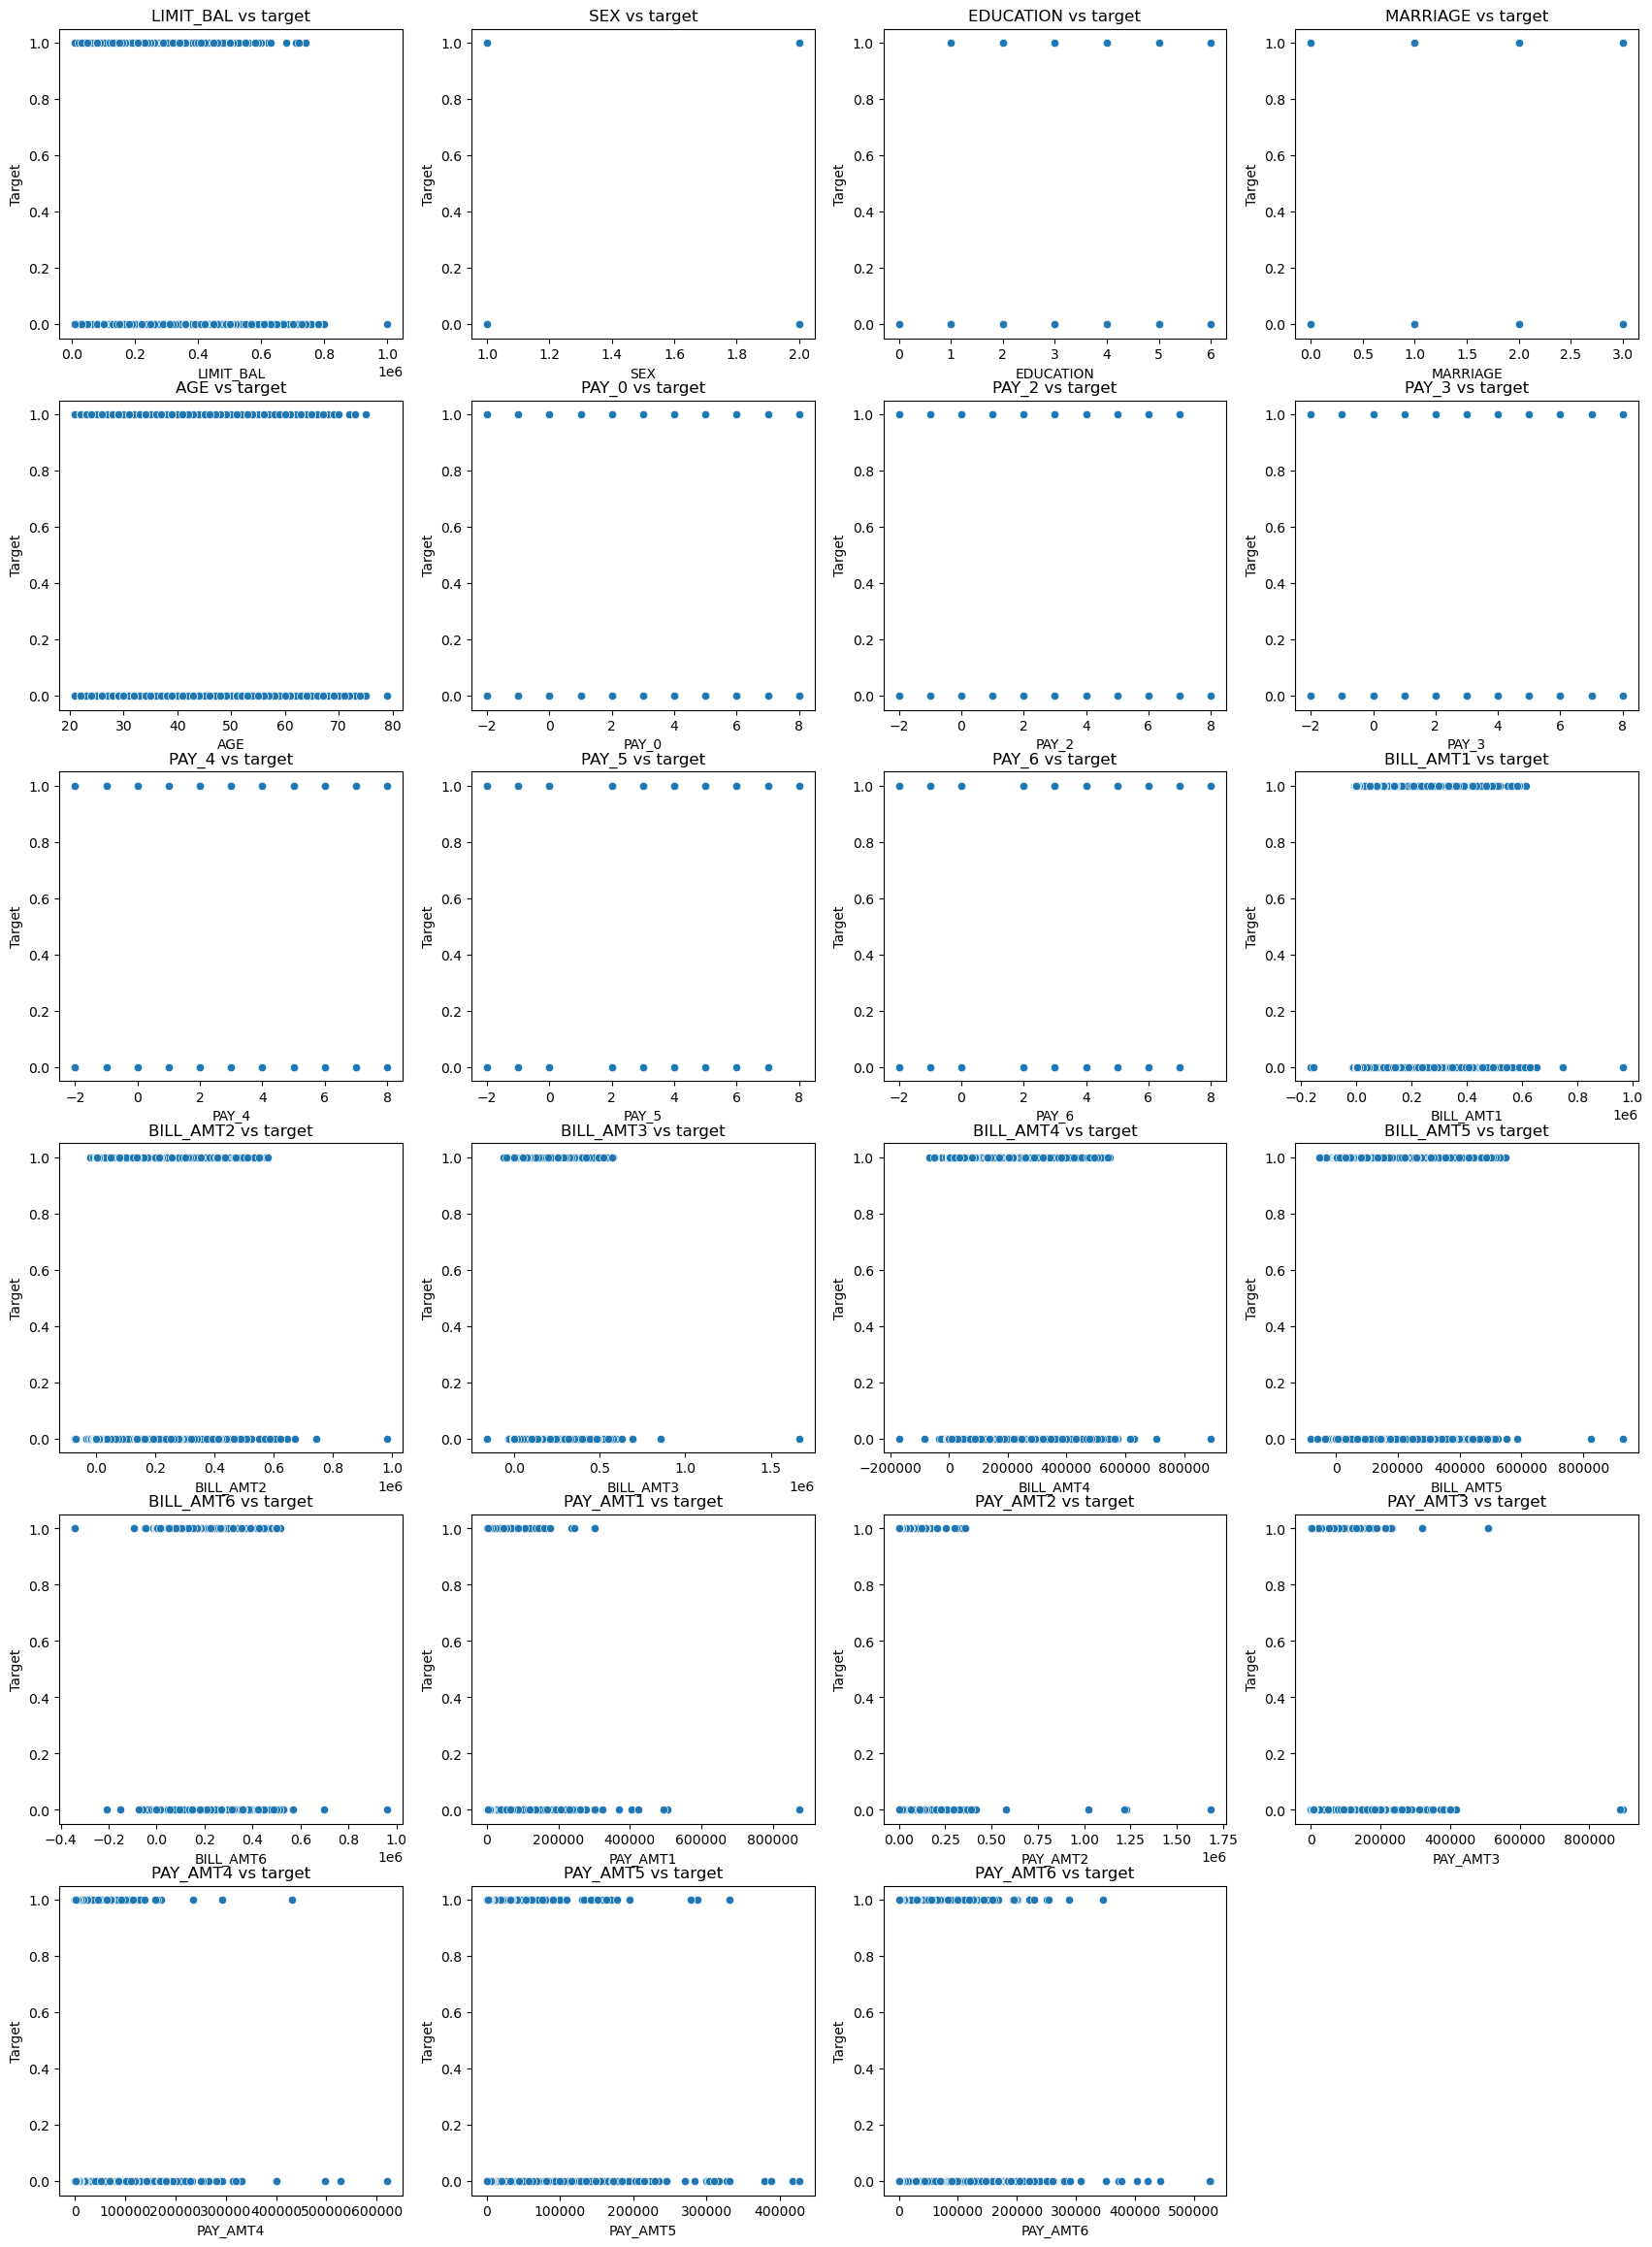

In [14]:
relaciones_vs_target(X, Y)

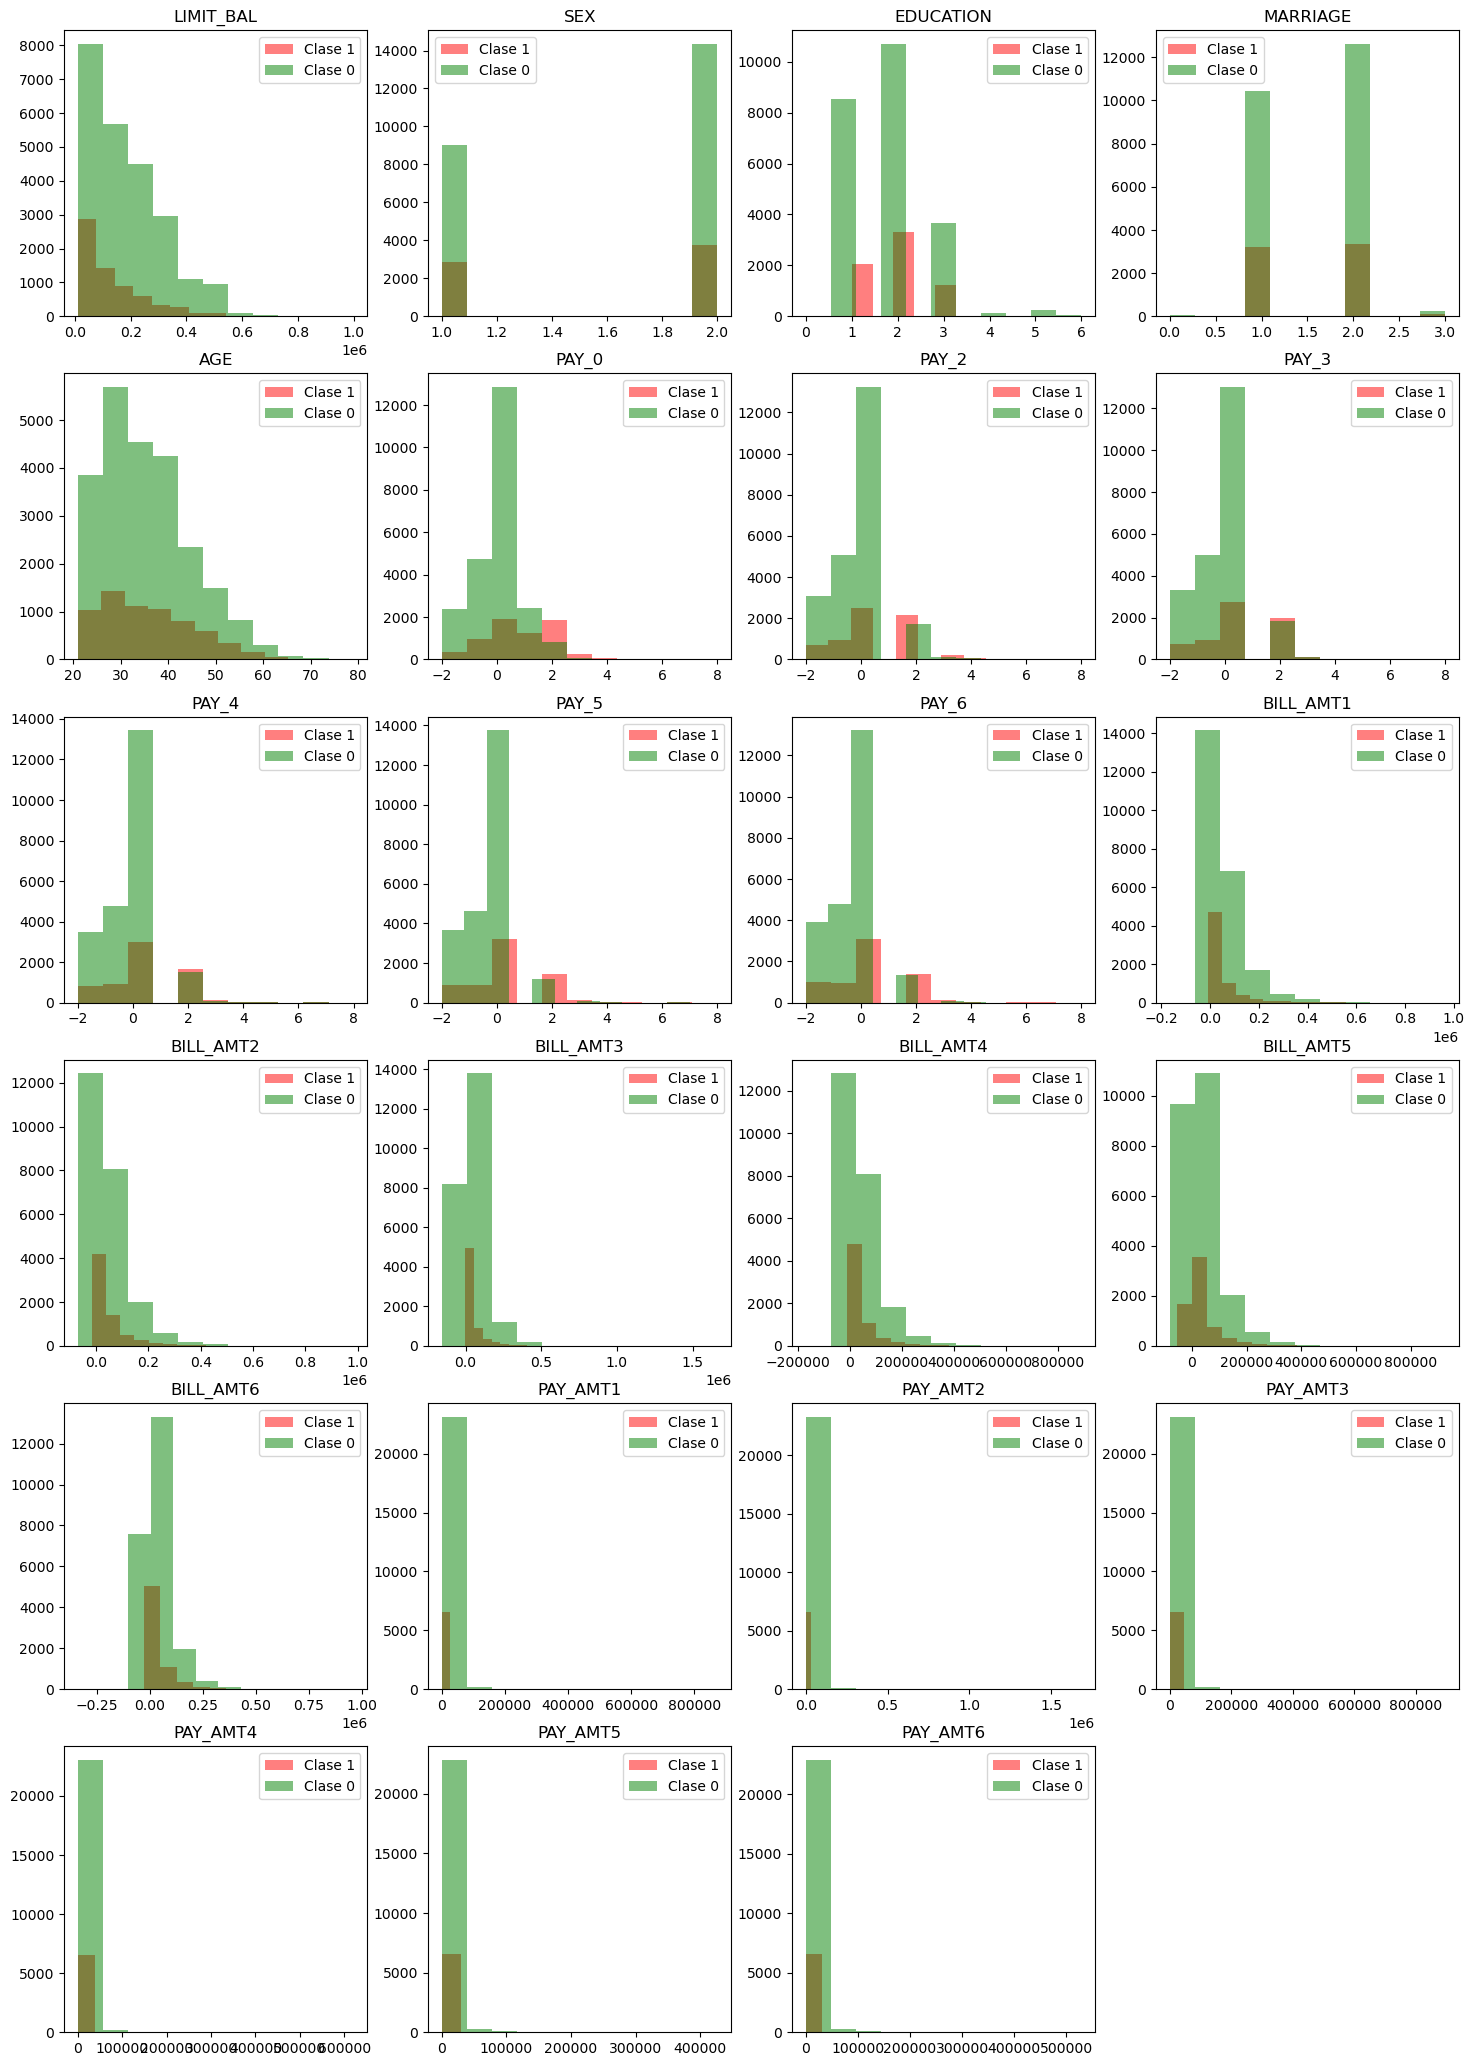

In [15]:
hist_pos_neg_feat(X,Y)

## Matriz de correlaciones: 

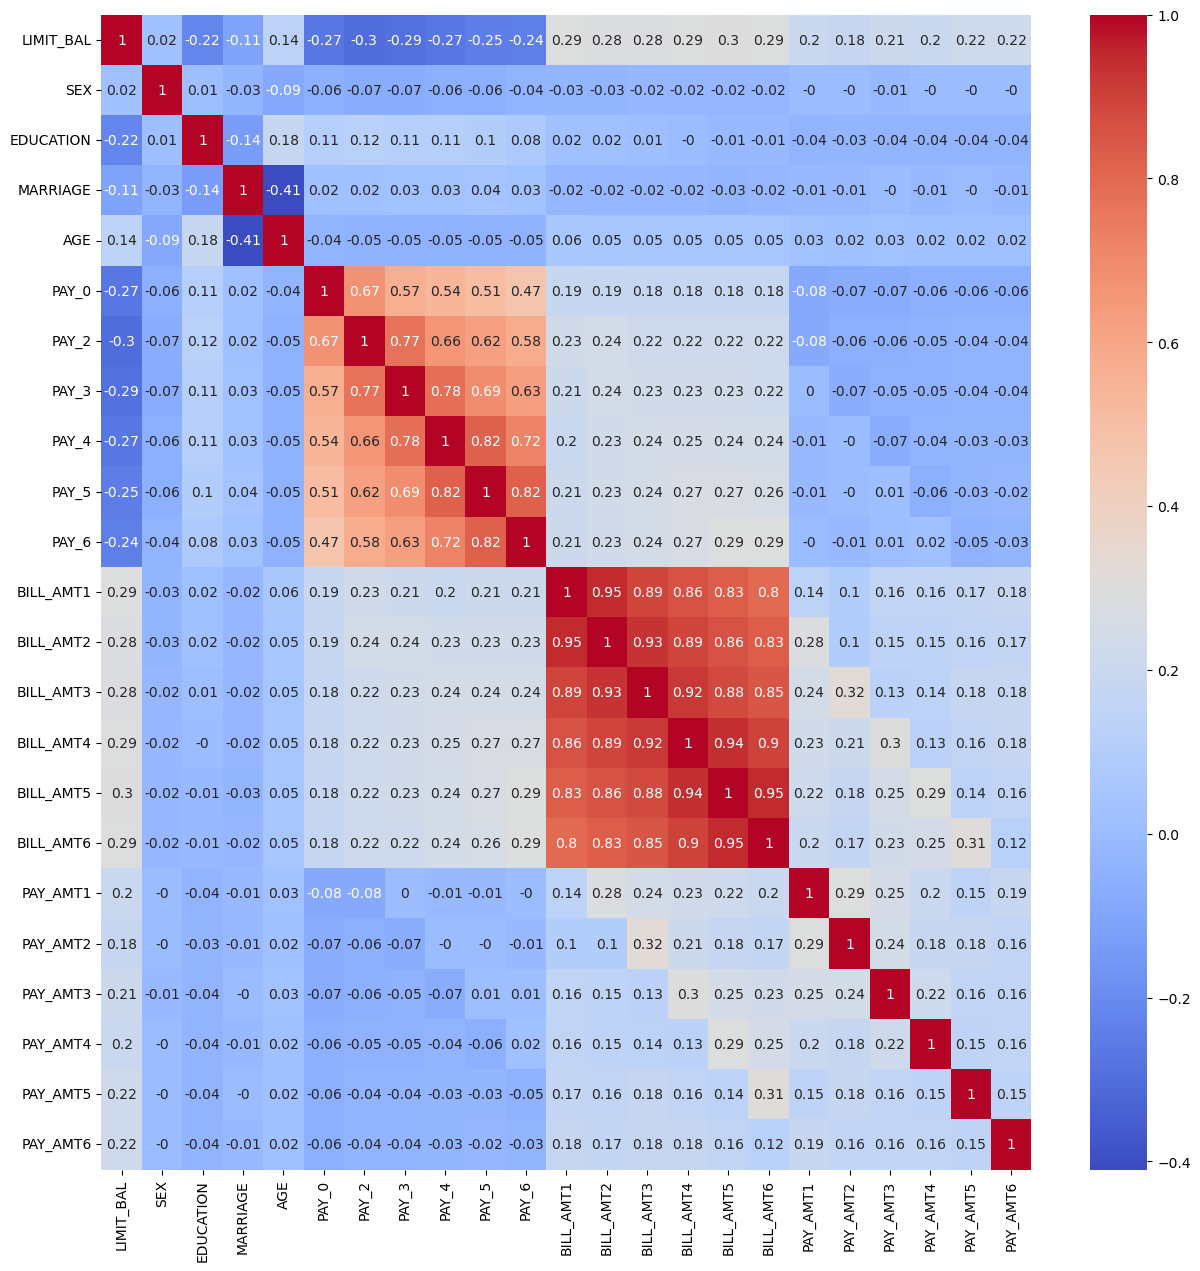

In [16]:
plt.figure( figsize=(15, 15) )
sns.heatmap(np.round(X.corr(method='pearson'),2), annot=True, cmap="coolwarm", fmt="g")
plt.show()

## Variables con mayor correlación con la target:

In [17]:
correlaciones_target = X.corr().values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
LIMIT_BAL,0.219595
PAY_AMT1,0.185735
BILL_AMT3,0.182326
BILL_AMT1,0.179341
BILL_AMT4,0.177637
BILL_AMT2,0.174256
BILL_AMT5,0.164184
PAY_AMT3,0.162740
PAY_AMT4,0.157834
PAY_AMT2,0.157634


## Estandarización previa de los datos: 

In [18]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test: 

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

# Aplicación de un modelo de redes neuronales

En este problema vamos a hacer uso de la librería **sklearn**. Esta librería cuenta con un clasificador llamado *MLPClassifier*, el cual es lo que se denomina un Multi-layer Perceptron Classifier.

Esta es la configuración más común y estándard de las redes neuronales. Cuentan con una capa de entrada, una de salida y múltiples capas ocultas. Se trata de una arquitectura de red neuronal **fully-connected**, es decir, las neuronas de cada capa se conectan a todas las neuronales de las capas anteriores y de las siguientes. En la imagen a continuación podéis ver un ejemplo de este tipo de redes neuronales.

<img src='mlp.jpeg' width=600></img>

In [20]:
modelo = MLPClassifier()
parametros = {'solver': ['lbfgs'], 
              'max_iter': [100,200,250], # Iteraciones máximas en cada red
              'alpha': 10.0 ** -np.arange(1, 3), # Parámetro de regularización L2 para evitar sobreajuste
              'hidden_layer_sizes':np.arange(30, 35), # Número de neuronas en cada capa
              'random_state':[0]}

In [21]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros, cv = 3, 
                         scoring='roc_auc', n_jobs=-1, verbose=10)

modelo_gs.fit(X_train, Y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'alpha': array([0.1 , 0.01]),
                         'hidden_layer_sizes': array([30, 31, 32, 33, 34]),
                         'max_iter': [100, 200, 250], 'random_state': [0],
                         'solver': ['lbfgs']},
             scoring='roc_auc', verbose=10)

In [22]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'alpha': 0.1, 'hidden_layer_sizes': 31, 'max_iter': 100, 'random_state': 0, 'solver': 'lbfgs'} 
ROC AUC: 0.77


## Mejores parámetros:

Igual que en el resto de modelos, obtenemos los mejores parámetros encontrados y ajustamos un modelo con esos parámetros:

In [23]:
mejor_modelo = MLPClassifier(**modelo_gs.best_params_, verbose=10)

In [24]:
mejor_modelo.fit(X_train, Y_train)

MLPClassifier(alpha=0.1, hidden_layer_sizes=31, max_iter=100, random_state=0,
              solver='lbfgs', verbose=10)

## Análisis de las predicciones:

In [25]:
y_test_pred_prob = mejor_modelo.predict_proba(X_test) 

In [26]:
y_test_pred_prob

array([[0.33073894, 0.66926106],
       [0.74097845, 0.25902155],
       [0.78283867, 0.21716133],
       ...,
       [0.83783112, 0.16216888],
       [0.27519787, 0.72480213],
       [0.86700653, 0.13299347]])

In [27]:
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

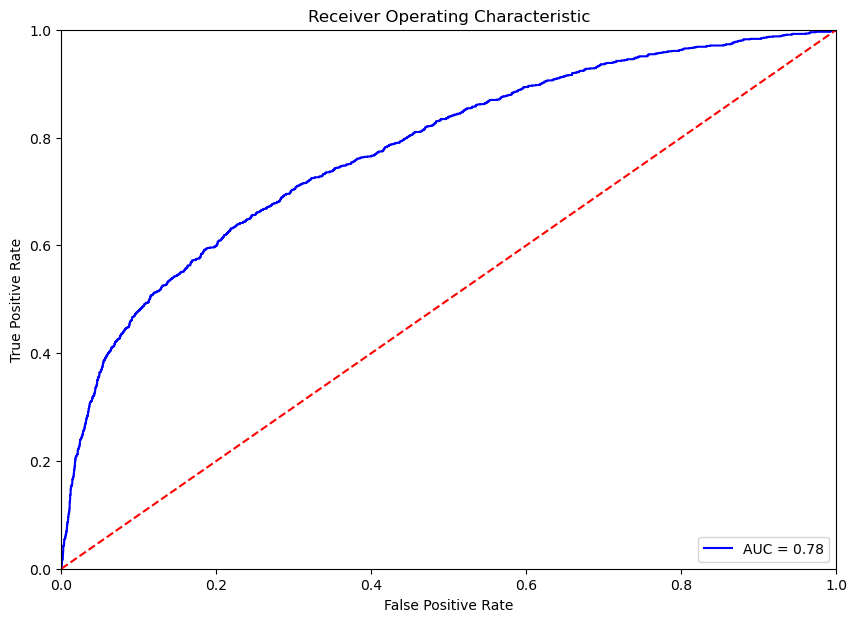

In [28]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

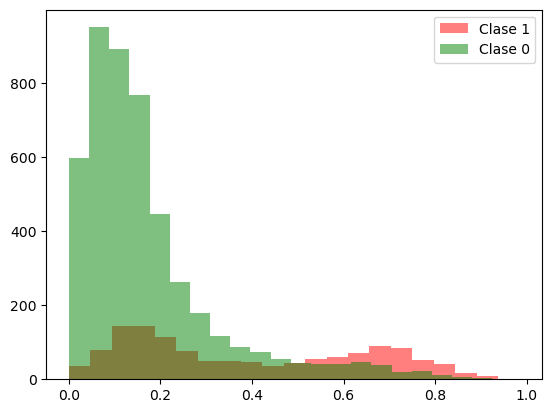

In [29]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

## Umbralizo las predicciones:

In [30]:
umbral = 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [31]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[4448  255]
 [ 802  495]]

Accuracy	0.82
Sensitividad	0.38
Precisión	0.66
